# **LIBRARY**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import euclidean

# **DATA UNDERSTANDING**

In [ ]:
df = pd.read_csv('cardio_train.csv', delimiter=';')

In [ ]:
# Bỏ cột 'id' vì nó không cần thiết cho việc gom cụm
if not df.empty and 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("Cột 'id' đã được loại bỏ.")
elif not df.empty:
    print("Không tìm thấy cột 'id' để loại bỏ.")

print("\n--- 5 dòng đầu tiên của dữ liệu ---")
if not df.empty:
    print(df.head())
else:
    print("DataFrame rỗng, không thể hiển thị .head()")


print("\n--- Thông tin tổng quan về dữ liệu ---")
if not df.empty:
    df.info()
    print("\n--> Thông tin này cho biết số lượng Non-Null (không trống) của mỗi cột và kiểu dữ liệu của chúng.")
else:
    print("DataFrame rỗng, không thể hiển thị .info()")


print("\n--- Kích thước của tập dữ liệu ---")
if not df.empty:
    print(f"Tập dữ liệu có {df.shape[0]} dòng (quan sát) và {df.shape[1]} cột (đặc trưng).")
else:
    print("DataFrame rỗng, không có kích thước để hiển thị.")


print("\n--- Kiểm tra giá trị thiếu ---")
if not df.empty:
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    if missing_values.sum() == 0:
        print("Không có giá trị thiếu (NaN) trong tập dữ liệu.")
    else:
        print("Các cột có giá trị thiếu:")
else:
    print("DataFrame rỗng, không thể kiểm tra giá trị thiếu.")

Cột 'id' đã được loại bỏ.

--- 5 dòng đầu tiên của dữ liệu ---
     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

--- Thông tin tổng quan về dữ liệu ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   he

In [ ]:
print("\n--- Thống kê mô tả cho các cột số ---")
print(df.describe())

# Chuyển đổi 'age' từ ngày sang năm
# Kiểm tra xem 'age_years' đã được tạo chưa để tránh tạo lại nếu cell được chạy nhiều lần
if 'age_years' not in df.columns:
    df['age_years'] = round(df['age'] / 365.25).astype(int)
    print("\n--- Thống kê mô tả cho 'age' sau khi chuyển đổi sang năm ---")
    print(df['age_years'].describe())

    print("\n--- Thống kê chi tiết cho các cột phân loại ---")
    # Các cột phân loại (bao gồm cả biến nhị phân)
    categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

    for col in categorical_cols:
        print(f"\n--- Thống kê cho cột: {col} ---")
        print(df[col].value_counts())
        print(f"Tỷ lệ phần trăm cho cột {col}:")
        print(df[col].value_counts(normalize=True) * 100)

    print("\n--- Kiểm tra các giá trị bất thường trong Huyết áp  ---")
    # Đây là trọng tâm chính của dự án, cần phân tích kỹ lưỡng
    print(f"Số lượng bản ghi có ap_hi < ap_lo: {len(df[df['ap_hi'] < df['ap_lo']])} (Lỗi logic nghiêm trọng)")
    print(f"Số lượng bản ghi có ap_hi quá cao (trên 250 mmHg): {len(df[df['ap_hi'] > 250])}")
    print(f"Số lượng bản ghi có ap_lo quá cao (trên 200 mmHg): {len(df[df['ap_lo'] > 200])}")
    print(f"Số lượng bản ghi có ap_hi quá thấp (dưới 70 mmHg): {len(df[df['ap_hi'] < 70])}")
    print(f"Số lượng bản ghi có ap_lo quá thấp (dưới 40 mmHg): {len(df[df['ap_lo'] < 40])}")


--- Thống kê mô tả cho các cột số ---
                age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   19468.865814      1.349571    164.359229     74.205690    128.817286   
std     2467.251667      0.476838      8.210126     14.395757    154.011419   
min    10798.000000      1.000000     55.000000     10.000000   -150.000000   
25%    17664.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      96.630414      1.366871      1.226457      0.088129      0.053771   
std      188

Tạo 'bmi' vì chưa được tạo.

--- Phân phối của các biến định lượng  ---


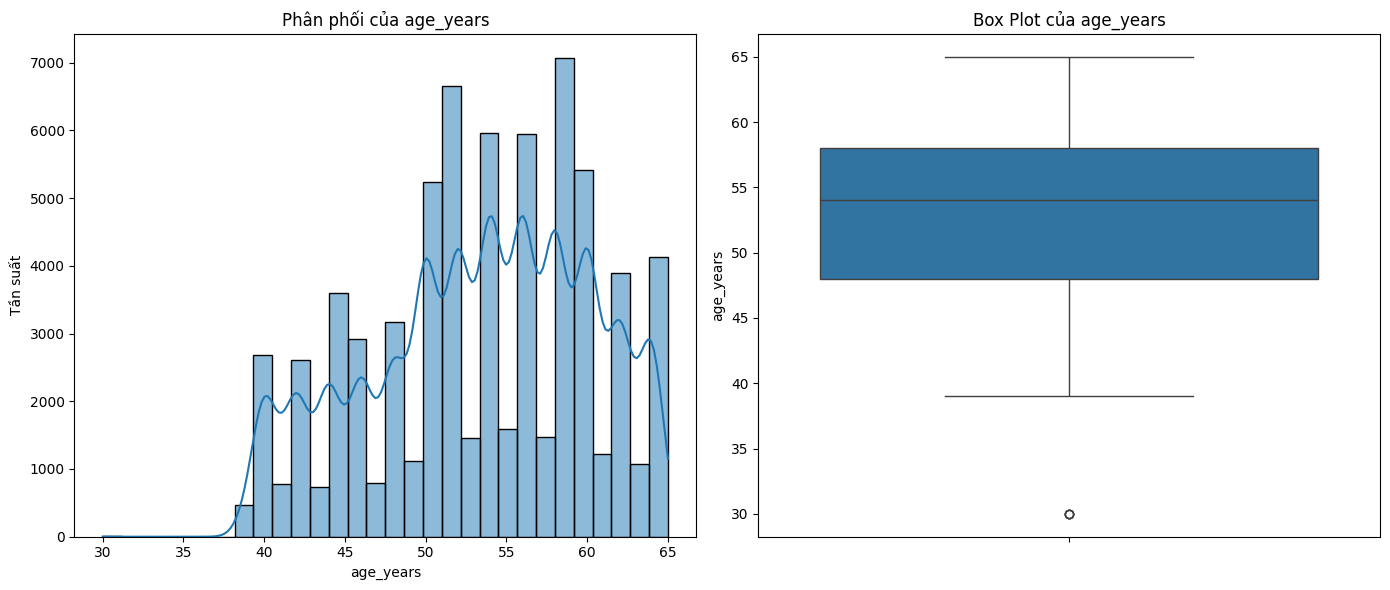

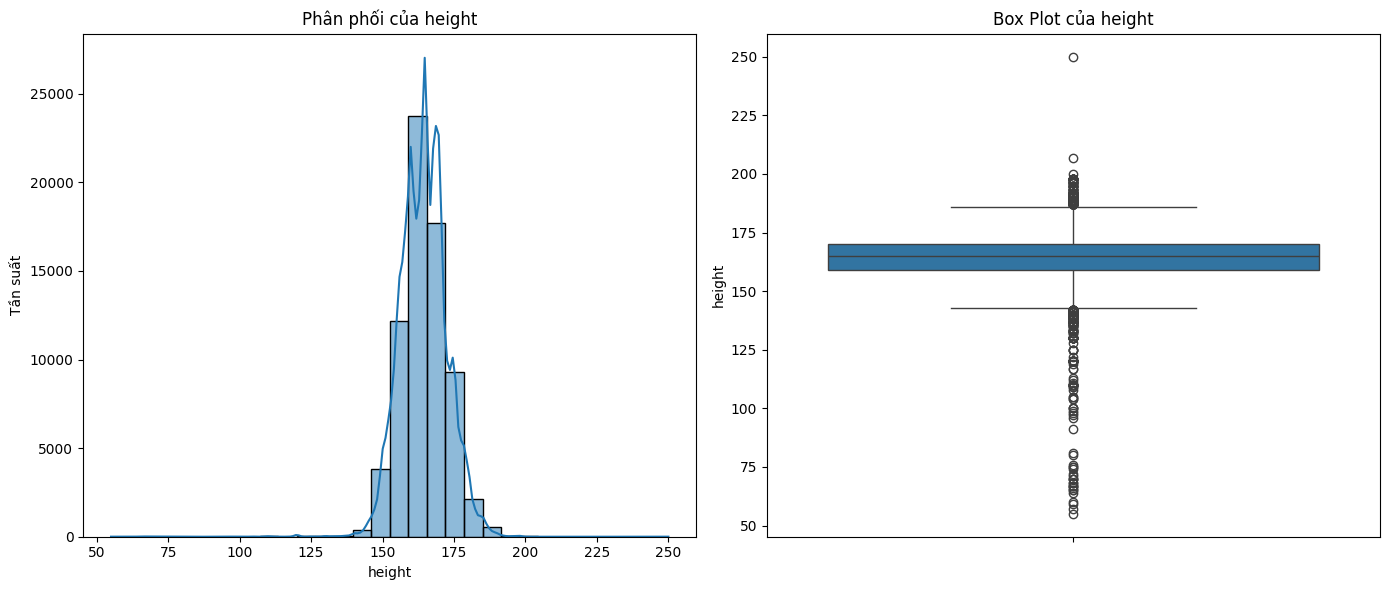

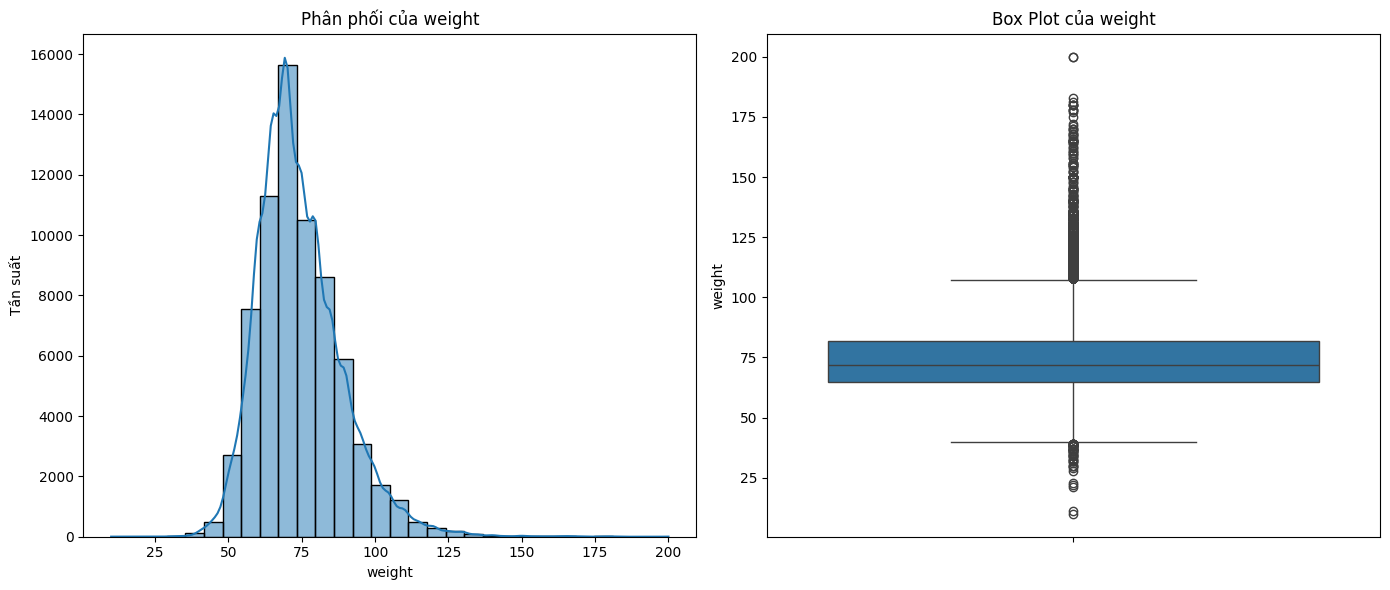

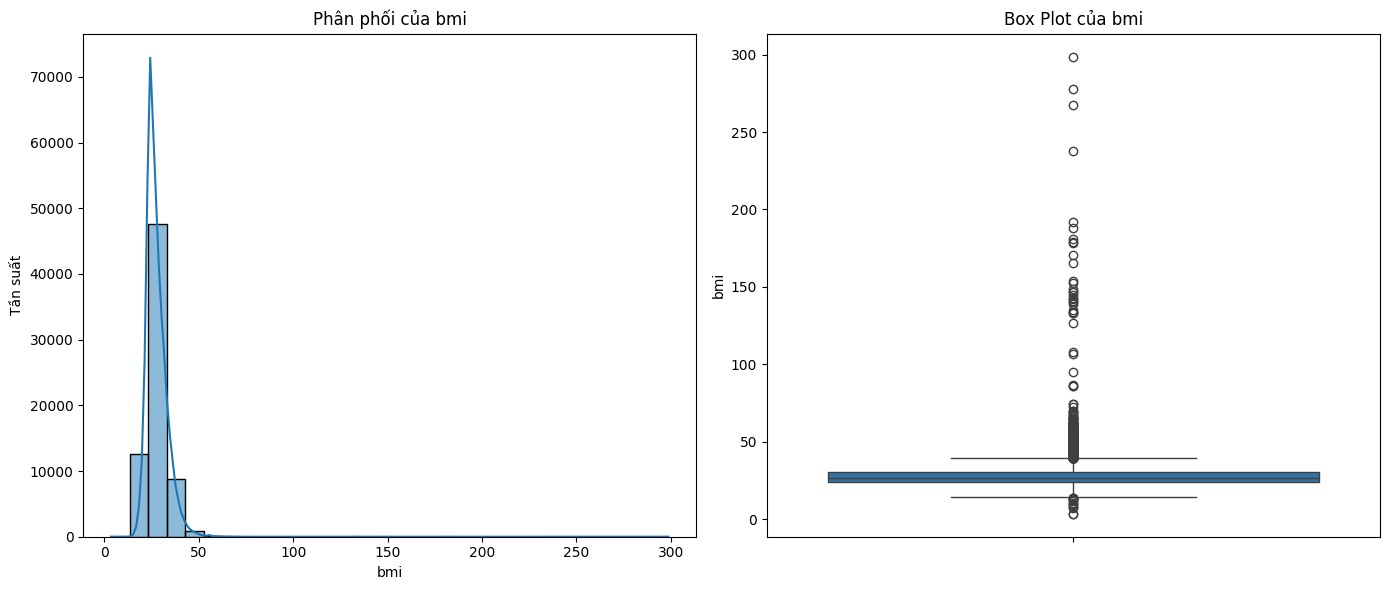

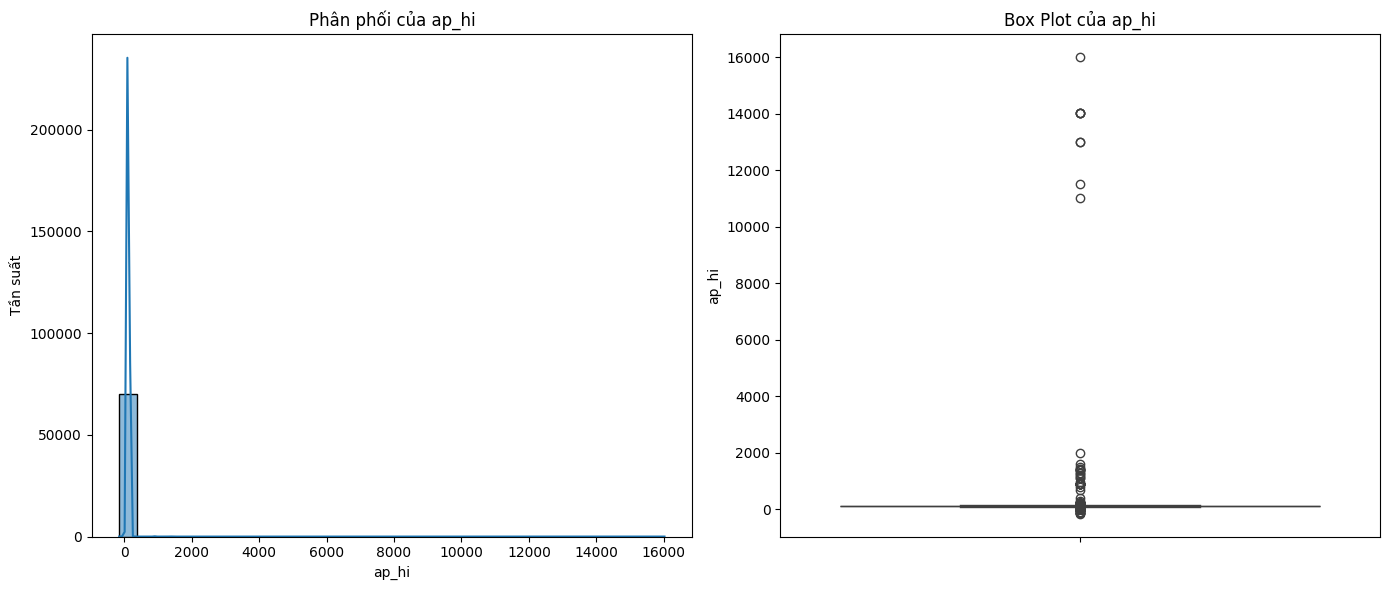

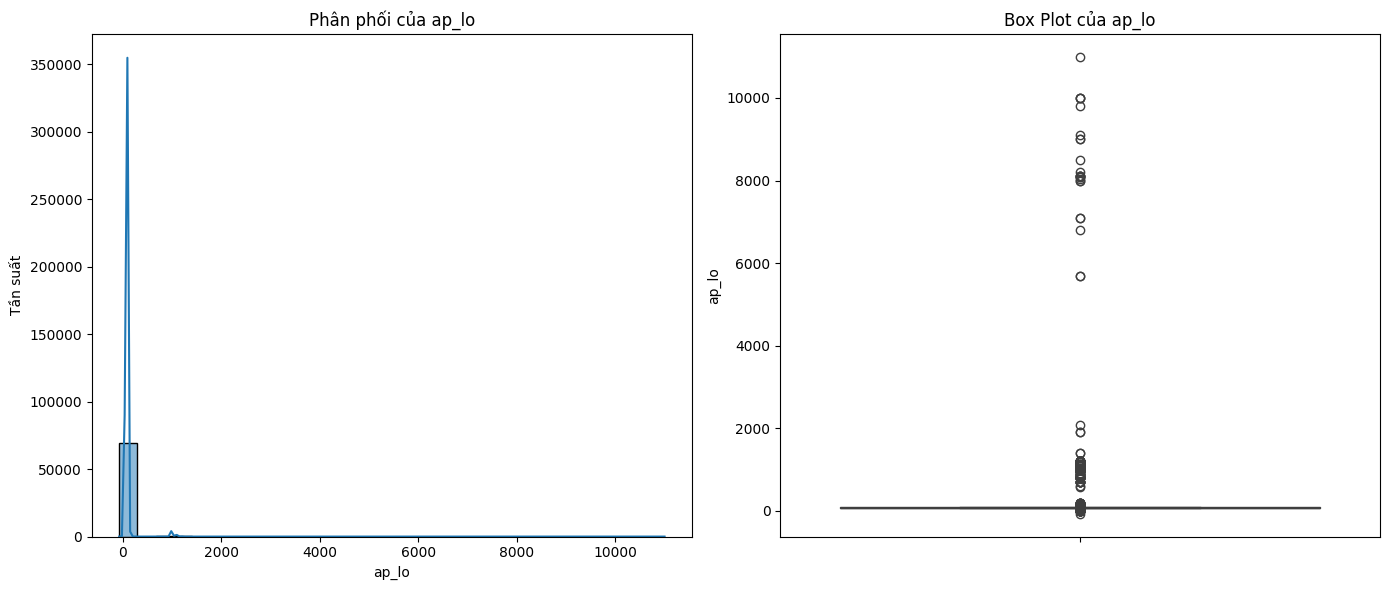


--- Phân phối của các biến phân loại ---


/tmp/ipython-input-8-3196065484.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='viridis')


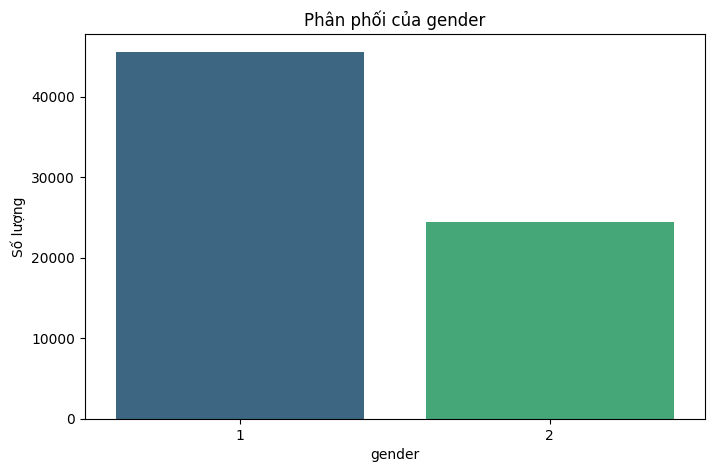

/tmp/ipython-input-8-3196065484.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='viridis')


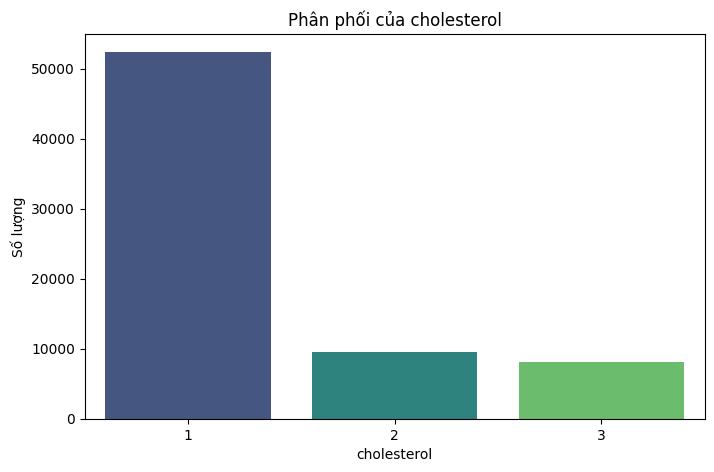

/tmp/ipython-input-8-3196065484.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='viridis')


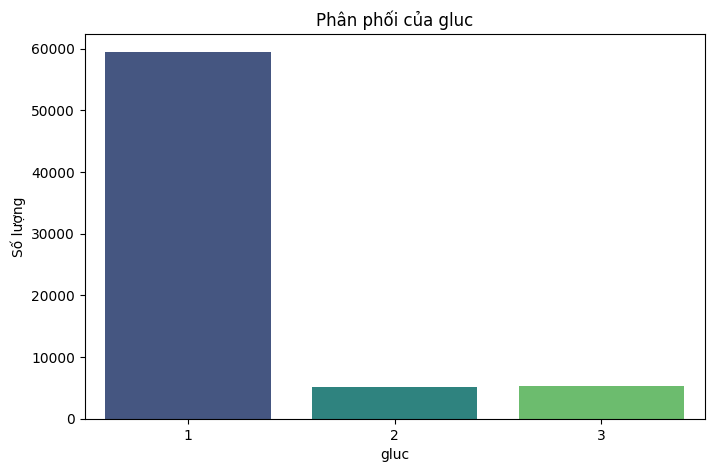

/tmp/ipython-input-8-3196065484.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='viridis')


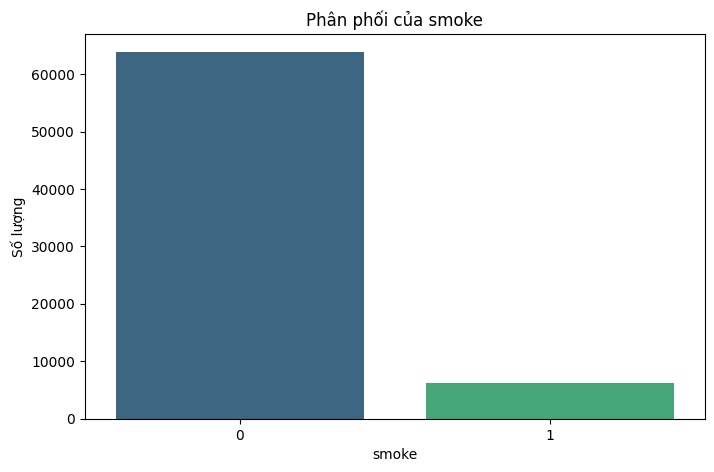

/tmp/ipython-input-8-3196065484.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='viridis')


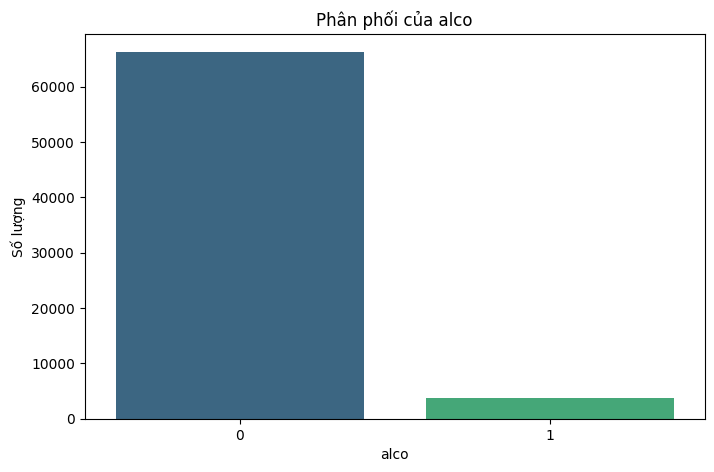

/tmp/ipython-input-8-3196065484.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='viridis')


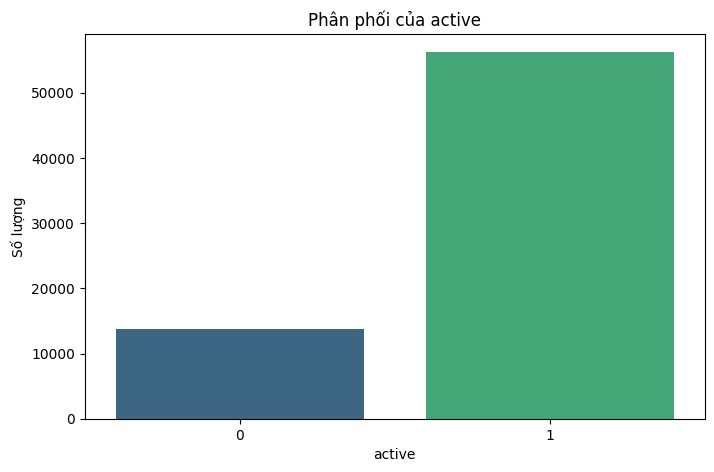

/tmp/ipython-input-8-3196065484.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='viridis')


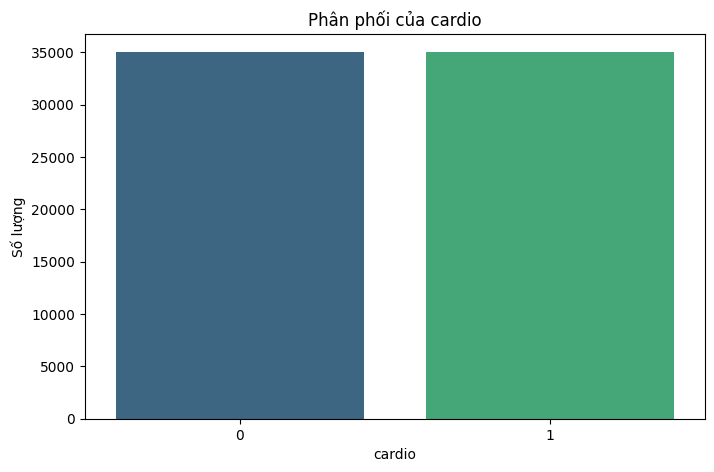


--- Trực quan hóa mối quan hệ giữa ap_hi và ap_lo ---


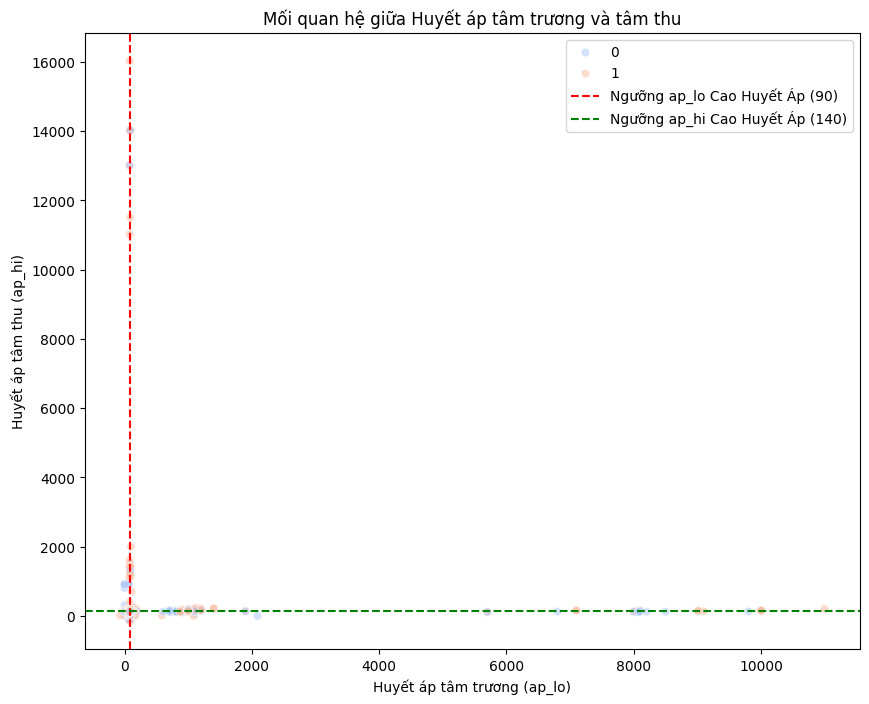


--- Ma trận tương quan giữa các đặc trưng (bao gồm ap_hi, ap_lo) ---


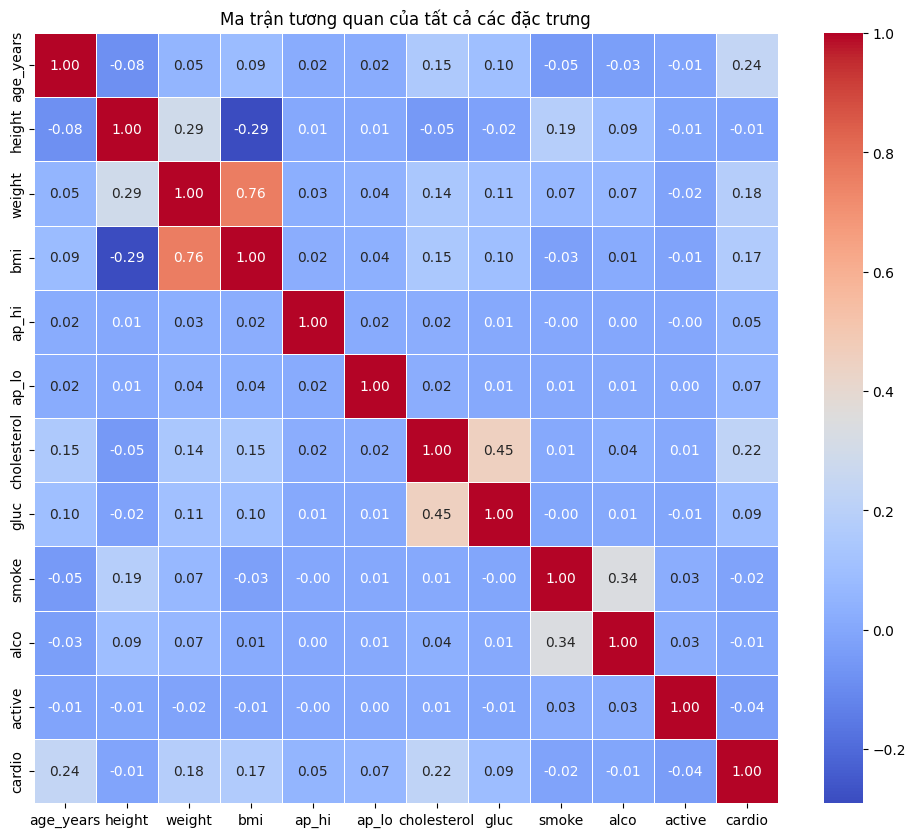


--- Mối quan hệ của các đặc trưng khác với ap_hi và ap_lo ---


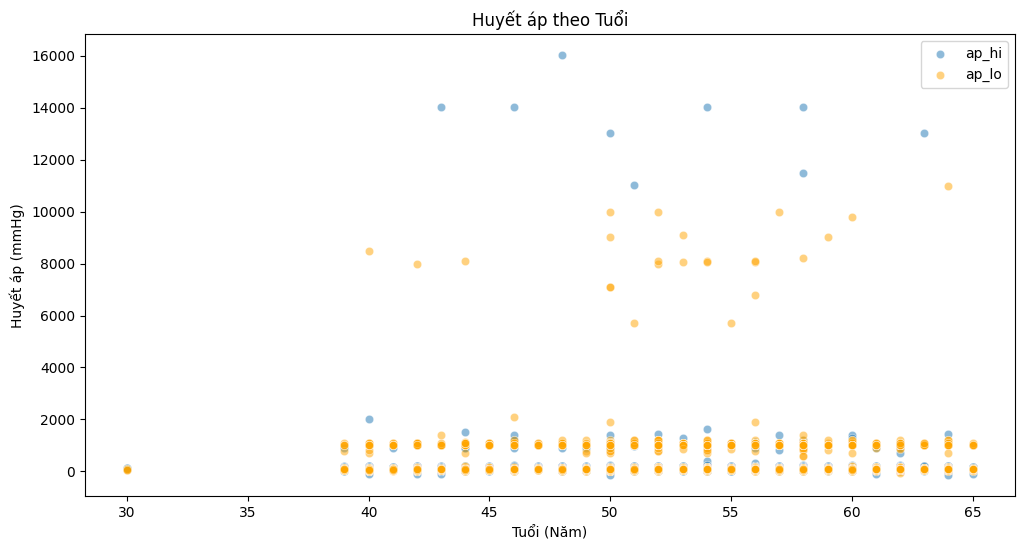

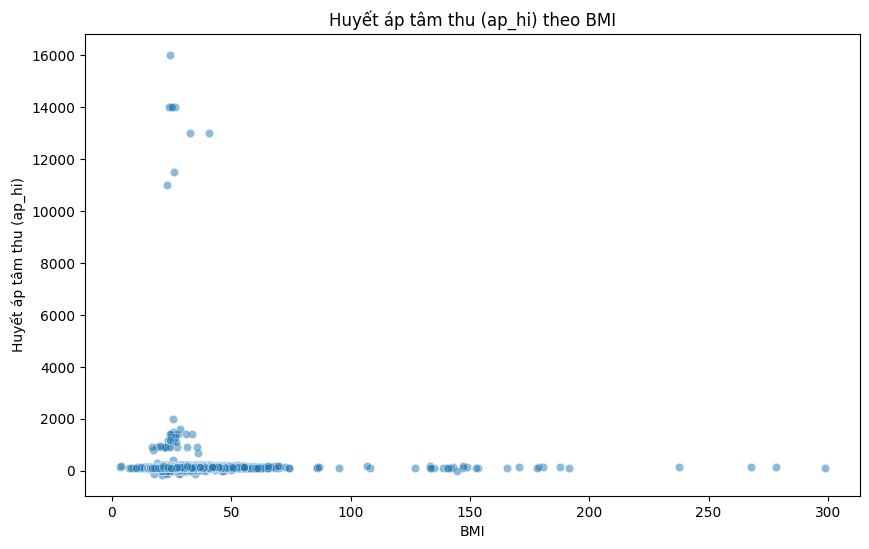

/tmp/ipython-input-8-3196065484.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cholesterol', y='ap_hi', data=df, palette='pastel')
/tmp/ipython-input-8-3196065484.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cholesterol', y='ap_lo', data=df, palette='pastel')


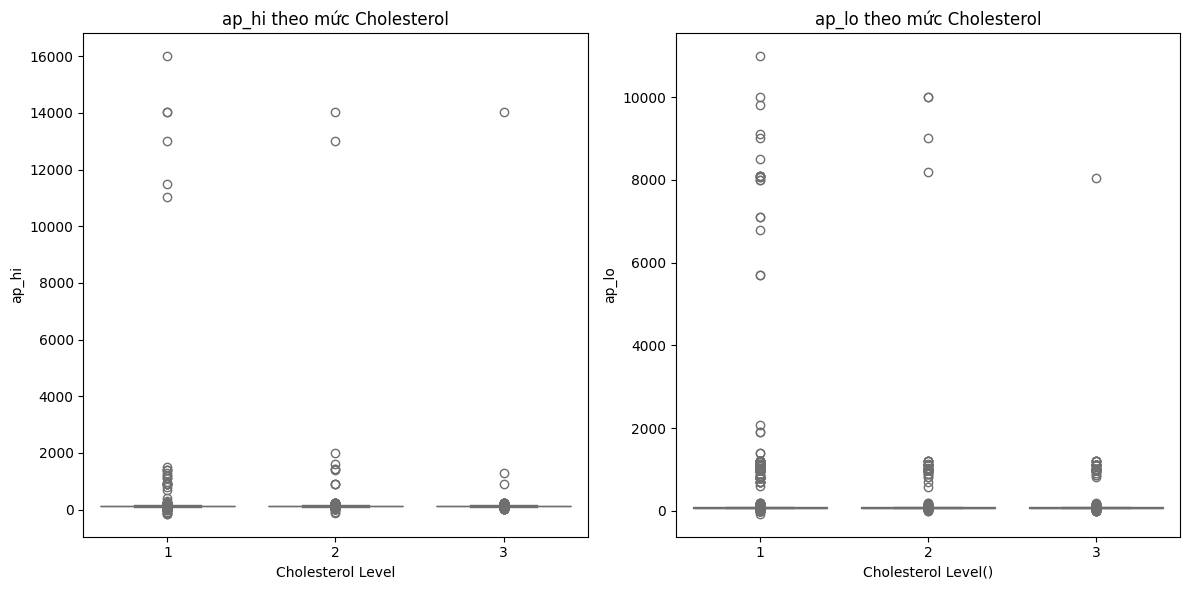

/tmp/ipython-input-8-3196065484.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='ap_hi', data=df, palette='coolwarm')
/tmp/ipython-input-8-3196065484.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='ap_lo', data=df, palette='coolwarm')


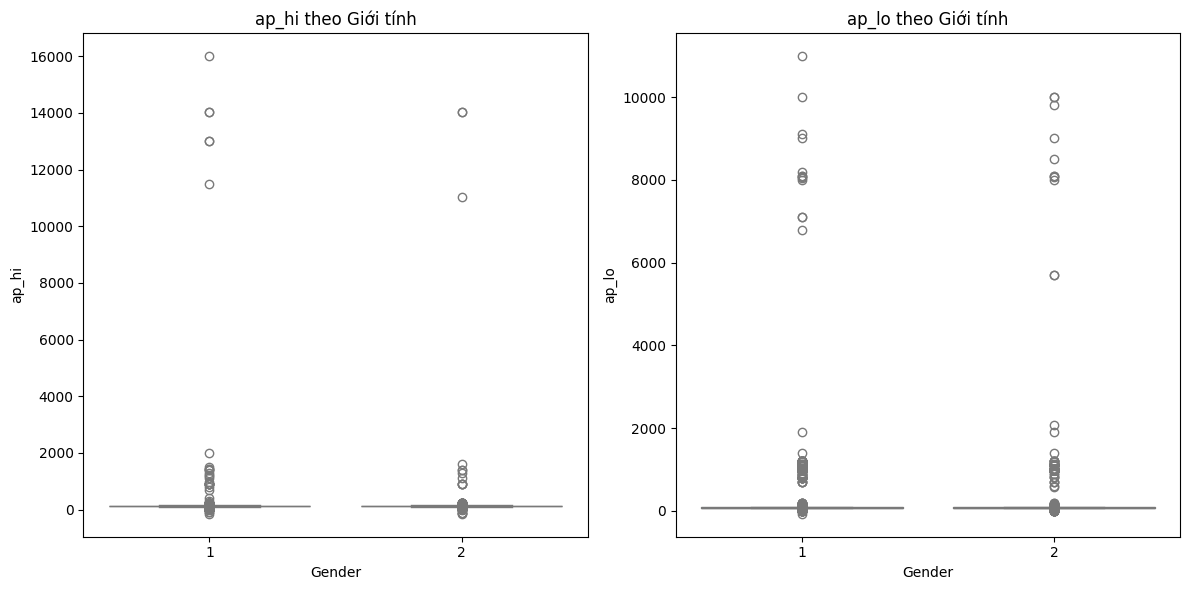

/tmp/ipython-input-8-3196065484.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_hi', data=df, palette='viridis')
/tmp/ipython-input-8-3196065484.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_lo', data=df, palette='viridis')


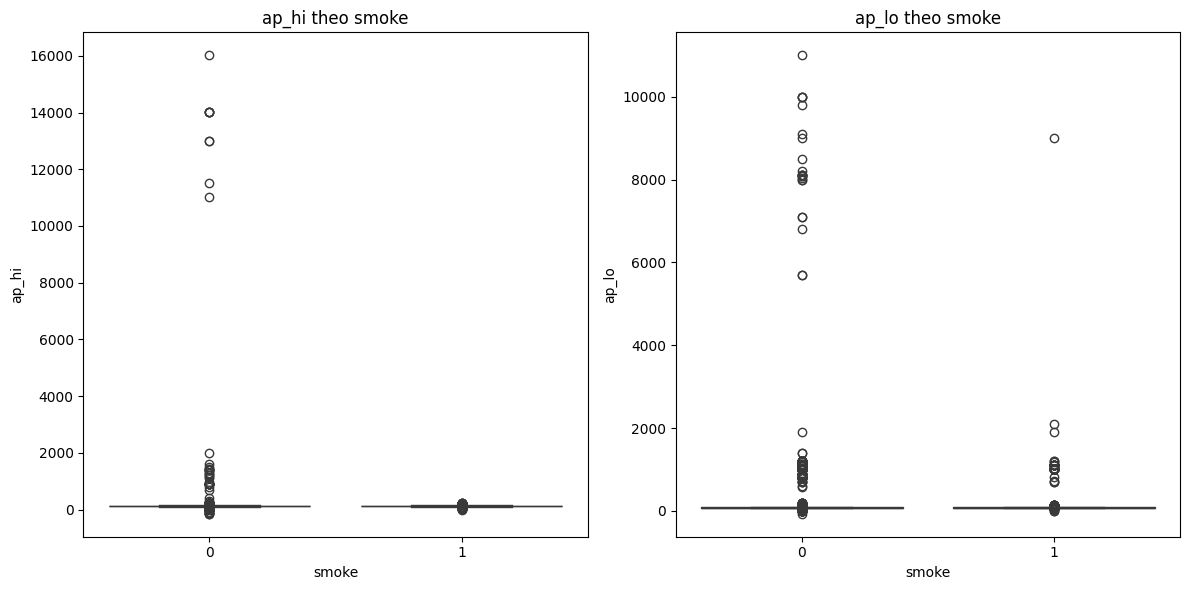

/tmp/ipython-input-8-3196065484.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_hi', data=df, palette='viridis')
/tmp/ipython-input-8-3196065484.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_lo', data=df, palette='viridis')


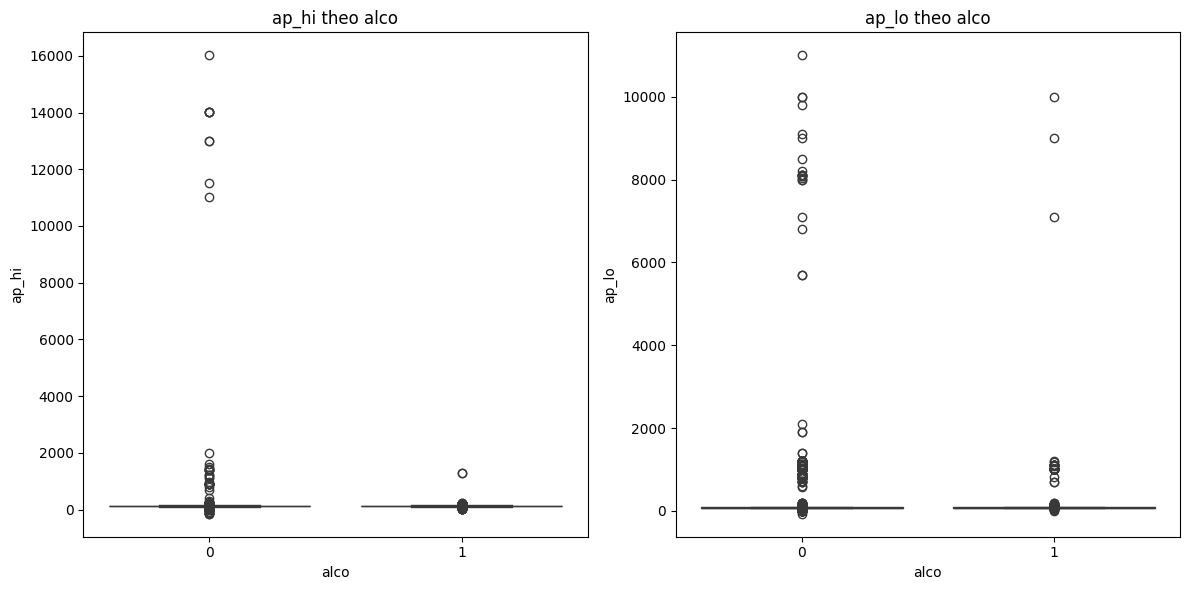

/tmp/ipython-input-8-3196065484.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_hi', data=df, palette='viridis')
/tmp/ipython-input-8-3196065484.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_lo', data=df, palette='viridis')


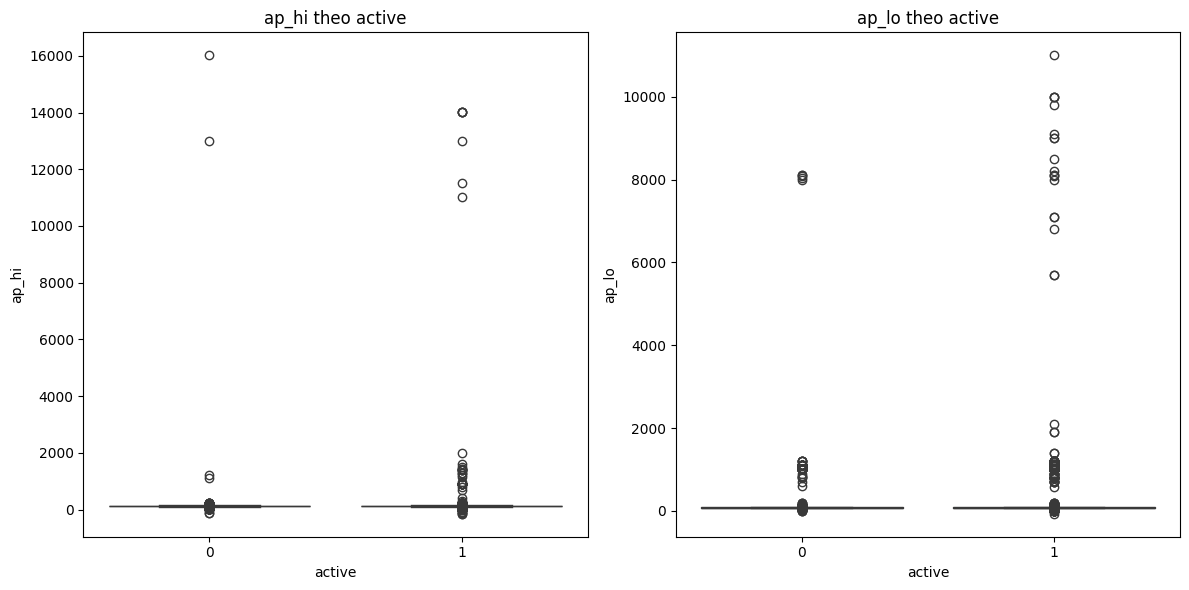

/tmp/ipython-input-8-3196065484.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_hi', data=df, palette='viridis')
/tmp/ipython-input-8-3196065484.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='ap_lo', data=df, palette='viridis')


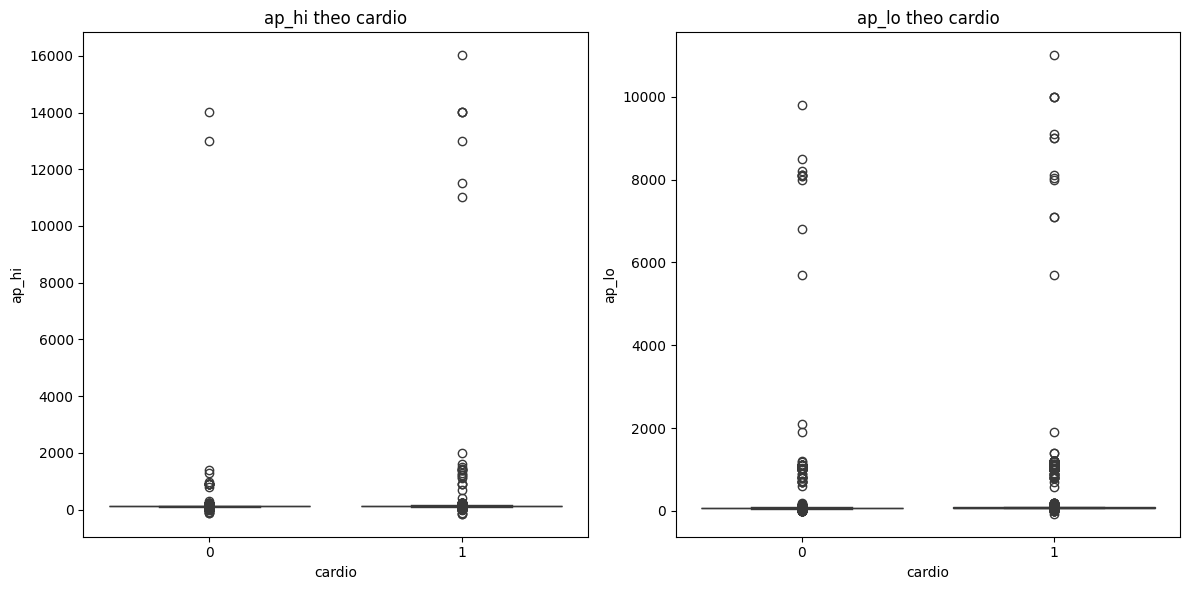

In [ ]:
if df.empty:
    print("DataFrame rỗng, không thể thực hiện trực quan hóa dữ liệu. Vui lòng kiểm tra Cell 1.")
else:
    if 'age_years' not in df.columns:
        df['age_years'] = round(df['age'] / 365.25).astype(int)
        print("Tạo 'age_years' vì chưa được tạo.")
    if 'bmi' not in df.columns:
        df['bmi'] = df['weight'] / (df['height'] / 100)**2
        print("Tạo 'bmi' vì chưa được tạo.")

    # Phân phối của các biến định lượng
    print("\n--- Phân phối của các biến định lượng  ---")
    numeric_features = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']

    for feature in numeric_features:
        plt.figure(figsize=(14, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(f'Phân phối của {feature}')
        plt.xlabel(feature)
        plt.ylabel('Tần suất')

        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[feature])
        plt.title(f'Box Plot của {feature}')
        plt.ylabel(feature)

        plt.tight_layout()
        plt.show()

    print("\n--- Phân phối của các biến phân loại ---")
    categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
    for feature in categorical_cols:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=feature, data=df, palette='viridis')
        plt.title(f'Phân phối của {feature}')
        plt.xlabel(feature)
        plt.ylabel('Số lượng')
        plt.show()

    #  Trực quan hóa mối quan hệ giữa ap_hi và ap_lo (Rất quan trọng cho gom cụm cao huyết áp)
    print("\n--- Trực quan hóa mối quan hệ giữa ap_hi và ap_lo ---")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='ap_lo', y='ap_hi', data=df, alpha=0.5, hue='cardio', palette='coolwarm')
    plt.title('Mối quan hệ giữa Huyết áp tâm trương và tâm thu')
    plt.xlabel('Huyết áp tâm trương (ap_lo)')
    plt.ylabel('Huyết áp tâm thu (ap_hi)')
    plt.axvline(x=90, color='r', linestyle='--', label='Ngưỡng ap_lo Cao Huyết Áp (90)') # Ngưỡng HATT >= 90
    plt.axhline(y=140, color='g', linestyle='--', label='Ngưỡng ap_hi Cao Huyết Áp (140)') # Ngưỡng HAT thu >= 140
    plt.legend()
    plt.show()

    # Ma trận tương quan giữa TẤT CẢ các biến để tìm mối quan hệ với ap_hi và ap_lo
    print("\n--- Ma trận tương quan giữa các đặc trưng (bao gồm ap_hi, ap_lo) ---")
    all_numeric_for_corr = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo',
                            'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
    correlation_matrix_all = df[all_numeric_for_corr].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Ma trận tương quan của tất cả các đặc trưng')
    plt.show()

    # Mối quan hệ của các đặc trưng với ap_hi và ap_lo
    print("\n--- Mối quan hệ của các đặc trưng khác với ap_hi và ap_lo ---")

    # Tuổi vs Huyết áp
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='age_years', y='ap_hi', data=df, alpha=0.5, label='ap_hi')
    sns.scatterplot(x='age_years', y='ap_lo', data=df, alpha=0.5, label='ap_lo', color='orange')
    plt.title('Huyết áp theo Tuổi')
    plt.xlabel('Tuổi (Năm)')
    plt.ylabel('Huyết áp (mmHg)')
    plt.legend()
    plt.show()


    # BMI vs Huyết áp
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='bmi', y='ap_hi', data=df, alpha=0.5)
    plt.title('Huyết áp tâm thu (ap_hi) theo BMI')
    plt.xlabel('BMI')
    plt.ylabel('Huyết áp tâm thu (ap_hi)')
    plt.show()

    # Cholesterol vs Huyết áp (Box Plot)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='cholesterol', y='ap_hi', data=df, palette='pastel')
    plt.title('ap_hi theo mức Cholesterol')
    plt.xlabel('Cholesterol Level')
    plt.ylabel('ap_hi')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='cholesterol', y='ap_lo', data=df, palette='pastel')
    plt.title('ap_lo theo mức Cholesterol')
    plt.xlabel('Cholesterol Level()')
    plt.ylabel('ap_lo')
    plt.tight_layout()
    plt.show()

    # Gender vs Huyết áp
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='gender', y='ap_hi', data=df, palette='coolwarm')
    plt.title('ap_hi theo Giới tính')
    plt.xlabel('Gender')
    plt.ylabel('ap_hi')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='gender', y='ap_lo', data=df, palette='coolwarm')
    plt.title('ap_lo theo Giới tính')
    plt.xlabel('Gender')
    plt.ylabel('ap_lo')
    plt.tight_layout()
    plt.show()

    # Kiểm tra các yếu tố nhị phân khác vs huyết áp
    binary_features = ['smoke', 'alco', 'active', 'cardio']
    for feature in binary_features:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(x=feature, y='ap_hi', data=df, palette='viridis')
        plt.title(f'ap_hi theo {feature}')
        plt.xlabel(feature)
        plt.ylabel('ap_hi')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=feature, y='ap_lo', data=df, palette='viridis')
        plt.title(f'ap_lo theo {feature}')
        plt.xlabel(feature)
        plt.ylabel('ap_lo')
        plt.tight_layout()
        plt.show()

**Đánh giá dữ liệu: **
1. Tóm tắt dữ liệu:
  Số lượng bản ghi: 70,000 dòng.

  Số lượng cột: 12 (bao gồm cả đặc trưng định lượng và định tính).

  Không có giá trị thiếu (NaN) trong dữ liệu.

  Các cột định tính: gender, cholesterol, gluc, smoke, alco, active, cardio.

  Các cột định lượng: age, height, weight, ap_hi, ap_lo.





2. Đặc điểm dữ liệu định lượng:
 Tuổi (age_years)

    Tuổi dao động từ 30 đến 65 (sau khi chuyển từ ngày sang năm).

    Phân phối: Phân phối không chuẩn hoàn toàn, có sự tập trung nhiều ở khoảng 50–60 tuổi.

    Boxplot: Có một số ngoại lệ nhỏ.

📌 Chiều cao (height)

    Trung bình: 164.4 cm, khá sát với mức trung bình của dân số trưởng thành.

    Có outlier cả ở dưới (dưới 100 cm) và trên (trên 200 cm).

📌 Cân nặng (weight)

    Trung bình: 74.2 kg, phân phối hơi lệch phải (có nhiều người nặng hơn mức trung bình).

    Có nhiều ngoại lệ với cân nặng rất lớn (>150 kg).

📌 Chỉ số BMI (bmi)

    Phân phối tập trung mạnh quanh khoảng 20–30, có nhiều giá trị ngoại lệ lớn (BMI > 50), điều này bất thường vì BMI lớn như vậy là hiếm.

📌 Huyết áp tâm thu (ap_hi) và tâm trương (ap_lo)

    Vấn đề nghiêm trọng: Có giá trị bất thường như ap_hi < ap_lo, hoặc ap_hi âm.

    Một số giá trị ap_hi lên tới hơn 16,000 và ap_lo lên tới 10,000, điều này không hợp lý về mặt sinh học và có thể do lỗi nhập liệu.

    Phân phối lệch phải rất mạnh, đa phần giá trị nằm trong khoảng sinh lý bình thường.
3. Đặc điểm dữ liệu định tính
📌 Giới tính (gender)

    Nam: ~65%, Nữ: ~35%, cân đối nhưng lệch về nam.

📌 Cholesterol và Gluc

    Cholesterol mức 1 chiếm ~75%.

    Gluc mức 1 chiếm ~85%, mức cao chỉ chiếm tỷ lệ nhỏ.

📌 Thói quen và hoạt động

    Smoke: Chỉ ~9% người hút thuốc.

    Alco: Chỉ ~5% người uống rượu.

    Active: ~80% người hoạt động thể chất thường xuyên.
4. Nhận xét tổng quan:
  Dữ liệu không thiếu giá trị và đa dạng về đặc trưng.
  Các biểu đồ histogram và boxplot cung cấp cái nhìn trực quan về phân phối của các biến.
  
  Vấn đề nghiêm trọng với ap_hi và ap_lo:

  - Cần lọc hoặc xử lý dữ liệu bất thường (ví dụ: ap_hi < ap_lo, ap_hi < 70, ap_lo < 40, ap_hi > 250, ap_lo > 200).
  - BMI có nhiều giá trị ngoại lệ lớn, nên kiểm tra dữ liệu gốc hoặc loại bỏ để tránh ảnh hưởng phân tích.
  - Phân phối giới tính, cholesterol, glucose, smoke, alco, active đều hợp lý, nhưng có thể cân nhắc thêm phân tích chi tiết theo nhóm tuổi hoặc nhóm bệnh lý.

# **DATA PREPARATION**

In [ ]:
print("\n--- Bước 1: Làm sạch dữ liệu ---")
df_cleaned = df.copy()

# Lọc giá trị huyết áp không hợp lý
df_cleaned = df_cleaned[
    (df_cleaned['ap_hi'] >= df_cleaned['ap_lo']) &
    (df_cleaned['ap_hi'] >= 70) & (df_cleaned['ap_hi'] <= 250) &
    (df_cleaned['ap_lo'] >= 40) & (df_cleaned['ap_lo'] <= 200)
]

# Loại bỏ BMI > 60 (outlier nặng)
df_cleaned = df_cleaned[df_cleaned['bmi'] <= 60]

# Đặt lại chỉ số dòng
df_cleaned.reset_index(drop=True, inplace=True)

print(f"Số bản ghi còn lại sau làm sạch: {df_cleaned.shape[0]}")


--- Bước 1: Làm sạch dữ liệu ---
Số bản ghi còn lại sau làm sạch: 68612


In [ ]:
# Chọn các đặc trưng số để áp dụng STING
numerical_features = ['ap_hi','ap_lo']

data_for_sting = df_cleaned[numerical_features].values

# Xác định giới hạn (min/max) của dữ liệu cho từng đặc trưng
data_min_bounds = data_for_sting.min(axis=0)
data_max_bounds = data_for_sting.max(axis=0)

print(f"\nGiới hạn dữ liệu cho STING (min): {data_min_bounds}")
print(f"Giới hạn dữ liệu cho STING (max): {data_max_bounds}")


Giới hạn dữ liệu cho STING (min): [70 40]
Giới hạn dữ liệu cho STING (max): [240 182]


# **MODELING**

In [ ]:
class GridCell:
    """
    Lưu và biểu diễn các giá trị của một ô lưới trong thuật toán STING.
    """
    def __init__(self, level, min_coords, max_coords):
        self.level = level         # Cấp độ của ô (0 là cao nhất)
        self.min_coords = np.array(min_coords) # Tọa độ tối thiểu của ô
        self.max_coords = np.array(max_coords) # Tọa độ tối đa của ô

        # Các tham số thống kê
        self.count = 0             # Số lượng điểm dữ liệu trong ô
        self.sum_val = np.zeros_like(self.min_coords, dtype=float) # Tổng các giá trị thuộc tính
        self.sum_sq_val = np.zeros_like(self.min_coords, dtype=float) # Tổng bình phương các giá trị thuộc tính

        self.children = []         # Các ô con ở cấp độ thấp hơn

    def update_stats(self, point):
        """Cập nhật các tham số thống kê của ô khi thêm một điểm."""
        self.count += 1
        self.sum_val += point
        self.sum_sq_val += point**2

    def get_mean(self):
        """Trả về giá trị trung bình của các thuộc tính."""
        if self.count == 0:
            return np.zeros_like(self.min_coords, dtype=float)
        return self.sum_val / self.count

    def get_std_dev(self):
        """Trả về độ lệch chuẩn của các thuộc tính."""
        if self.count <= 1:
            return np.zeros_like(self.min_coords, dtype=float)
        # Sử dụng công thức Var(X) = E[X^2] - (E[X])^2
        variance = (self.sum_sq_val / self.count) - (self.get_mean()**2)
        # Đảm bảo variance không âm do lỗi số học nhỏ
        variance[variance < 0] = 0
        return np.sqrt(variance)

    def contains(self, point):
        """Kiểm tra xem một điểm có nằm trong ô này không."""
        return np.all(point >= self.min_coords) and np.all(point <= self.max_coords)

    def __repr__(self):
        return (f"Cell(Level={self.level}, Count={self.count}, "
                f"Min={self.min_coords}, Max={self.max_coords})")

In [ ]:
class STING:
    """
    Triển khai thuật toán STING.
    """
    def __init__(self, data_min, data_max, num_levels, num_divisions):
        self.data_min = np.array(data_min)
        self.data_max = np.array(data_max)
        self.num_levels = num_levels     # Số lượng cấp độ phân cấp (ví dụ: 3 cấp)
        self.num_divisions = num_divisions # Số lần chia mỗi chiều (ví dụ: 2x2 = 4 ô con)

        self.grid_levels = [] # Danh sách các cấp độ, mỗi cấp là một danh sách các ô

        self._build_grid_hierarchy()

    def _build_grid_hierarchy(self):
        """
        Xây dựng cấu trúc lưới phân cấp từ cấp cao nhất xuống.
        Hỗ trợ số chiều tự động dựa trên data_min/max.
        """
        dims = len(self.data_min)

        # Cấp cao nhất (root)
        root_cell = GridCell(0, self.data_min, self.data_max)
        self.grid_levels.append([root_cell])

        # Xây dựng các cấp độ còn lại
        for level in range(1, self.num_levels):
            current_level_cells = []
            for parent_cell in self.grid_levels[level - 1]:
                cell_range = parent_cell.max_coords - parent_cell.min_coords
                division_step = cell_range / self.num_divisions

                # Tạo các ô con cho N chiều
                # Sử dụng itertools.product để tạo tất cả các tổ hợp ranh giới
                from itertools import product

                # Tạo các mảng ranh giới cho mỗi chiều
                min_coords_options = [
                    [parent_cell.min_coords[d] + i * division_step[d]
                     for i in range(self.num_divisions)]
                    for d in range(dims)
                ]
                max_coords_options = [
                    [parent_cell.min_coords[d] + (i + 1) * division_step[d]
                     for i in range(self.num_divisions)]
                    for d in range(dims)
                ]

                # Kết hợp các tùy chọn để tạo tọa độ min/max cho từng ô con
                for min_tuple, max_tuple in zip(product(*min_coords_options), product(*max_coords_options)):
                    child_min_coords = list(min_tuple)
                    child_max_coords = list(max_tuple)
                    child_cell = GridCell(level, child_min_coords, child_max_coords)
                    parent_cell.children.append(child_cell)
                    current_level_cells.append(child_cell)
            self.grid_levels.append(current_level_cells)

    def _find_leaf_cell(self, point):
        """Tìm ô lá (ô ở cấp thấp nhất) mà điểm thuộc về."""
        current_cell = self.grid_levels[0][0] # Bắt đầu từ ô gốc
        for level in range(1, self.num_levels):
            found_child = False
            for child in current_cell.children:
                # Kiểm tra xem điểm có nằm trong khoảng [min_coords, max_coords)
                # để tránh các điểm nằm trên biên được tính 2 lần hoặc không được tính
                # Đối với float, có thể có vấn đề với dấu bằng, nên cần xử lý cẩn thận
                if np.all(point >= child.min_coords) and np.all(point < child.max_coords):
                    current_cell = child
                    found_child = True
                    break
            # Trường hợp điểm nằm chính xác trên biên của ô cuối cùng trong một chiều,
            # đảm bảo nó vẫn được bao gồm trong ô max_coords của chiều đó.
            if not found_child and level == self.num_levels - 1:
                # Kiểm tra lại cho ô lá cuối cùng nếu không tìm thấy bằng '<'
                # Điều này giúp bao gồm các điểm nằm trên ranh giới trên cùng
                for child in current_cell.children:
                    if np.all(point >= child.min_coords) and np.all(point <= child.max_coords):
                        current_cell = child
                        found_child = True
                        break
            if not found_child:
                break # Nếu điểm không nằm trong bất kỳ ô con nào, dừng lại
        return current_cell

    def insert_data(self, data_points):
        """
        Chèn các điểm dữ liệu vào lưới và cập nhật thống kê.
        """
        for point in data_points:
            point = np.array(point)
            # Tìm ô lá mà điểm thuộc về
            leaf_cell = self._find_leaf_cell(point)

            # Cập nhật thống kê của ô lá
            leaf_cell.update_stats(point)

        # Sau khi chèn tất cả dữ liệu vào các ô lá, chúng ta cần tính toán lại
        # thống kê cho các ô ở cấp cao hơn từ dưới lên.
        for level in range(self.num_levels - 2, -1, -1): # Duyệt từ cấp ngay trên cấp lá lên gốc
            for cell in self.grid_levels[level]:
                cell.count = sum(child.count for child in cell.children)
                cell.sum_val = sum(child.sum_val for child in cell.children)
                cell.sum_sq_val = sum(child.sum_sq_val for child in cell.children)


    def query_clusters(self, query_rect, min_density_threshold, target_level=None):
        """
        Truy vấn các cụm dựa trên một hình chữ nhật và ngưỡng mật độ.
        """
        if target_level is None:
            target_level = self.num_levels - 1 # Mặc định truy vấn ở cấp thấp nhất

        candidate_cells = []
        # Bắt đầu từ cấp độ cao nhất
        cells_to_check = [self.grid_levels[0][0]]

        while cells_to_check:
            current_cell = cells_to_check.pop(0)

            # Kiểm tra xem ô có chồng lấp với vùng truy vấn không
            if not (np.all(current_cell.min_coords <= query_rect[1]) and
                    np.all(current_cell.max_coords >= query_rect[0])):
                continue # Bỏ qua ô không nằm trong vùng truy vấn

            # Ước lượng mật độ của ô
            cell_volume = np.prod(current_cell.max_coords - current_cell.min_coords)
            density = current_cell.count / cell_volume if cell_volume > 0 else 0

            # Kiểm tra ngưỡng mật độ
            if density >= min_density_threshold:
                if current_cell.level == target_level:
                    candidate_cells.append(current_cell)
                elif current_cell.level < target_level:
                    cells_to_check.extend(current_cell.children) # Duyệt xuống ô con
            # Nếu mật độ quá thấp, không cần duyệt xuống nữa

        return candidate_cells

In [ ]:
# Khởi tạo thuật toán STING
# nums_levels: số cấp độ của lưới (ví dụ: 3)
# num_divisions: số lần chia mỗi chiều (ví dụ: 2 -> ô chia thành 2x2=4 ô con)
# Bạn có thể thử nghiệm với các giá trị khác nhau để xem kết quả.
sting_algo = STING(data_min_bounds, data_max_bounds, num_levels=2, num_divisions=6)

print("\nChèn dữ liệu vào lưới STING...")
sting_algo.insert_data(data_for_sting)
print("Đã chèn dữ liệu vào lưới.")

# In thông tin thống kê của một vài ô mẫu
print("\n--- Thông tin các ô lưới (Cấp 0 - Gốc) ---")
for cell in sting_algo.grid_levels[0]:
    print(cell)
    print(f"  Mean: {cell.get_mean().round(2)}, Std Dev: {cell.get_std_dev().round(2)}")

print("\n--- Thông tin các ô lưới (Cấp 1) ---")
# Chỉ in 5 ô đầu tiên để tránh quá nhiều output nếu số lượng ô lớn
for cell in sting_algo.grid_levels[1][:5]:
    print(cell)
    print(f"  Mean: {cell.get_mean().round(2)}, Std Dev: {cell.get_std_dev().round(2)}")

print("\n--- Thông tin các ô lưới (Cấp 2 - Cấp lá) ---")
# Chỉ in các ô có chứa dữ liệu và có số lượng điểm > 0
count_leaf_cells_with_data = 0
for cell in sting_algo.grid_levels[1]:
    if cell.count > 0:
        print(cell)
        print(f"  Mean: {cell.get_mean().round(2)}, Std Dev: {cell.get_std_dev().round(2)}")
        count_leaf_cells_with_data += 1
    if count_leaf_cells_with_data >= 10: # Giới hạn số lượng in ra để dễ đọc
        print("...(và nhiều ô khác có dữ liệu)")
        break

print(f"\nTổng số ô lá có chứa dữ liệu: {count_leaf_cells_with_data}")


Chèn dữ liệu vào lưới STING...
Đã chèn dữ liệu vào lưới.

--- Thông tin các ô lưới (Cấp 0 - Gốc) ---
Cell(Level=0, Count=68612, Min=[70 40], Max=[240 182])
  Mean: [126.67  81.31], Std Dev: [16.69  9.45]

--- Thông tin các ô lưới (Cấp 1) ---
Cell(Level=1, Count=875, Min=[70. 40.], Max=[98.33333333 63.66666667])
  Mean: [89.34 59.53], Std Dev: [2.93 2.3 ]
Cell(Level=1, Count=184, Min=[70.         63.66666667], Max=[98.33333333 87.33333333])
  Mean: [90.09 70.61], Std Dev: [2.14 3.44]
Cell(Level=1, Count=0, Min=[70.         87.33333333], Max=[ 98.33333333 111.        ])
  Mean: [0. 0.], Std Dev: [0. 0.]
Cell(Level=1, Count=0, Min=[ 70. 111.], Max=[ 98.33333333 134.66666667])
  Mean: [0. 0.], Std Dev: [0. 0.]
Cell(Level=1, Count=0, Min=[ 70.         134.66666667], Max=[ 98.33333333 158.33333333])
  Mean: [0. 0.], Std Dev: [0. 0.]

--- Thông tin các ô lưới (Cấp 2 - Cấp lá) ---
Cell(Level=1, Count=875, Min=[70. 40.], Max=[98.33333333 63.66666667])
  Mean: [89.34 59.53], Std Dev: [2.93 2.3 

In [ ]:
# Thực hiện truy vấn để tìm các cụm
# Vùng truy vấn: toàn bộ không gian dữ liệu
query_rect = (data_min_bounds, data_max_bounds)

# Ngưỡng mật độ: Đây là tham số quan trọng và cần được điều chỉnh.
# Nó phụ thuộc vào mật độ thực tế của dữ liệu và kích thước ô.
# Ví dụ: Nếu ô có kích thước 100x10x5x10x10 = 500,000 đơn vị thể tích,
# và bạn muốn ô phải có ít nhất 100 điểm, thì mật độ là 100/500,000 = 0.0002.
# Hoặc thử nghiệm với các giá trị nhỏ hơn cho đến khi tìm thấy cụm.

# Đối với tập dữ liệu thực tế, bạn có thể cần thử nhiều ngưỡng khác nhau.
# Hãy bắt đầu với một giá trị nhỏ và tăng dần.
min_density = 0.1 # Giá trị ví dụ, cần điều chỉnh

# target_level: Mức độ chi tiết của cụm. Thường là cấp lá (num_levels - 1).
# Bạn có thể chọn một cấp cao hơn để có các cụm lớn hơn, tổng quát hơn.
target_level_for_query = sting_algo.num_levels - 1 # Cấp lá

print(f"\n--- Thực hiện truy vấn cụm với ngưỡng mật độ {min_density} và cấp độ đích {target_level_for_query} ---")
clusters_found_cells = sting_algo.query_clusters(query_rect, min_density, target_level=target_level_for_query)

if clusters_found_cells:
    print(f"Tìm thấy {len(clusters_found_cells)} ô đáp ứng điều kiện mật độ:")
    # In ra thông tin của 5 cụm đầu tiên (nếu có nhiều)
    for i, cell in enumerate(clusters_found_cells):
        #if i >= 5:
            #print("...(và nhiều cụm khác)")
            #break
        cell_volume = np.prod(cell.max_coords - cell.min_coords)
        density = cell.count / cell_volume if cell_volume > 0 else 0
        print(f"  {cell} (Mật độ: {density:.6f})")
else:
    print("Không tìm thấy cụm nào với ngưỡng mật độ đã cho. Vui lòng điều chỉnh 'min_density'.")

print("\n--- Gợi ý điều chỉnh ---")
print("Nếu không có cụm nào được tìm thấy, hãy thử giảm giá trị 'min_density'.")
print("Nếu quá nhiều cụm được tìm thấy, hãy thử tăng giá trị 'min_density'.")
print("Bạn cũng có thể thay đổi 'num_levels' và 'num_divisions' khi khởi tạo STING để thay đổi kích thước ô.")


--- Thực hiện truy vấn cụm với ngưỡng mật độ 0.1 và cấp độ đích 1 ---
Tìm thấy 12 ô đáp ứng điều kiện mật độ:
  Cell(Level=1, Count=875, Min=[70. 40.], Max=[98.33333333 63.66666667]) (Mật độ: 1.304888)
  Cell(Level=1, Count=184, Min=[70.         63.66666667], Max=[98.33333333 87.33333333]) (Mật độ: 0.274399)
  Cell(Level=1, Count=1780, Min=[98.33333333 40.        ], Max=[126.66666667  63.66666667]) (Mật độ: 2.654515)
  Cell(Level=1, Count=36589, Min=[98.33333333 63.66666667], Max=[126.66666667  87.33333333]) (Mật độ: 54.565203)
  Cell(Level=1, Count=1452, Min=[98.33333333 87.33333333], Max=[126.66666667 111.        ]) (Mật độ: 2.165369)
  Cell(Level=1, Count=152, Min=[126.66666667  40.        ], Max=[155.          63.66666667]) (Mật độ: 0.226678)
  Cell(Level=1, Count=8955, Min=[126.66666667  63.66666667], Max=[155.          87.33333333]) (Mật độ: 13.354598)
  Cell(Level=1, Count=14041, Min=[126.66666667  87.33333333], Max=[155. 111.]) (Mật độ: 20.939354)
  Cell(Level=1, Count=588, Mi


--- Trực quan hóa kết quả cụm ---


/tmp/ipython-input-17-1383831894.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((row['Min_0'], row['Min_1']),


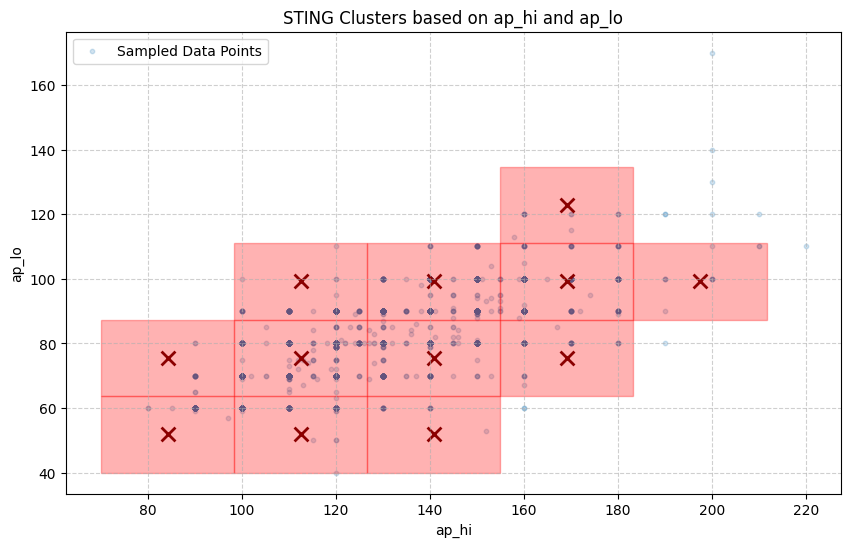

In [ ]:
# Chuẩn bị dữ liệu cho trực quan hóa
# Tạo DataFrame từ các ô cụm đã tìm thấy
if clusters_found_cells:
    cluster_data = []
    for cell in clusters_found_cells:
        # Sử dụng điểm trung tâm của ô hoặc min/max coords để biểu diễn ô
        center_point = (cell.min_coords + cell.max_coords) / 2
        cluster_data.append({
             numerical_features[0]: center_point[0],
             numerical_features[1]: center_point[1],
            'Min_0': cell.min_coords[0],
            'Max_0': cell.max_coords[0],
            'Min_1': cell.min_coords[1],
            'Max_1': cell.max_coords[1],
            'Count': cell.count,
            'Level': cell.level
        })

    df_clusters = pd.DataFrame(cluster_data)

    # Trực quan hóa các ô cụm
    print("\n--- Trực quan hóa kết quả cụm ---")

    # Biểu đồ Scatter plot của dữ liệu gốc và các ô cụm
    plt.figure(figsize=(10, 6))

    # Lấy dữ liệu gốc sau PCA
    data_for_plot = data_for_sting # data_for_sting now contains the PCA results

    # Vẽ các điểm dữ liệu gốc (tùy chọn, có thể gây quá tải nếu dữ liệu lớn)
    # Chỉ vẽ một mẫu nhỏ các điểm để tránh quá tải
    sample_size = 5000 # Điều chỉnh kích thước mẫu nếu cần
    if len(data_for_plot) > sample_size:
        sample_indices = np.random.choice(len(data_for_plot), size=sample_size, replace=False)
        plt.scatter(data_for_plot[sample_indices, 0], data_for_plot[sample_indices, 1],
                    alpha=0.2, label='Sampled Data Points', s=10)
    else:
        plt.scatter(data_for_plot[:, 0], data_for_plot[:, 1],
                    alpha=0.2, label='All Data Points', s=10)


    # Vẽ các ô cụm dưới dạng hình chữ nhật
    for index, row in df_clusters.iterrows():
        # Vẽ hình chữ nhật cho ô cụm
        rect = plt.Rectangle((row['Min_0'], row['Min_1']),
                             row['Max_0'] - row['Min_0'],
                             row['Max_1'] - row['Min_1'],
                             fill=True, color='red', alpha=0.3, edgecolor='black', linewidth=1)
        plt.gca().add_patch(rect)

        # Tùy chọn: Thêm tâm của cụm (sử dụng min/max coords để tính tâm trong không gian gốc)
        center_x = (row['Min_0'] + row['Max_0']) / 2
        center_y = (row['Min_1'] + row['Max_1']) / 2
        plt.scatter(center_x, center_y, color='darkred', marker='x', s=100, linewidths=2)
        #plt.text(center_x, center_y, f"Count: {row['Count']}", fontsize=8, ha='center')


    plt.title(f'STING Clusters based on ap_hi and ap_lo')
    plt.xlabel('ap_hi')
    plt.ylabel('ap_lo')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

else:
    print("Không có cụm nào được tìm thấy để trực quan hóa. Vui lòng điều chỉnh ngưỡng mật độ.")

# **EVALUATION**


--- Trực quan hóa từng ô cụm riêng biệt ---

Biểu đồ cho Ô cụm 0 (Level 1, Count 875)


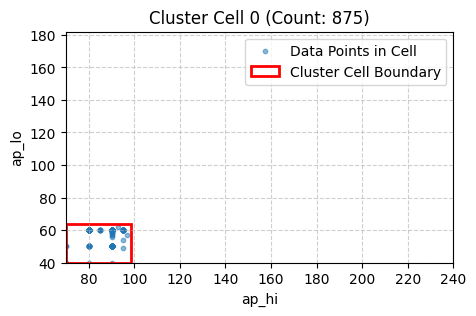


Biểu đồ cho Ô cụm 1 (Level 1, Count 184)


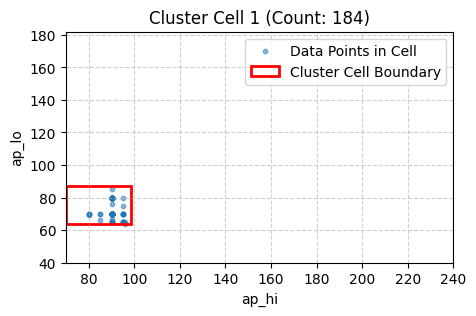


Biểu đồ cho Ô cụm 2 (Level 1, Count 1780)


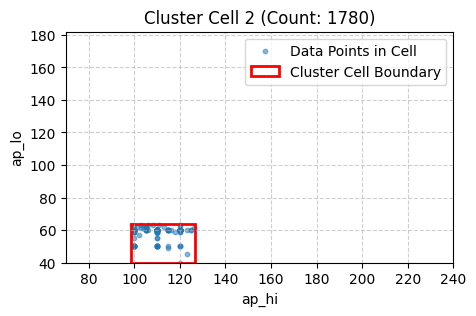


Biểu đồ cho Ô cụm 3 (Level 1, Count 36589)


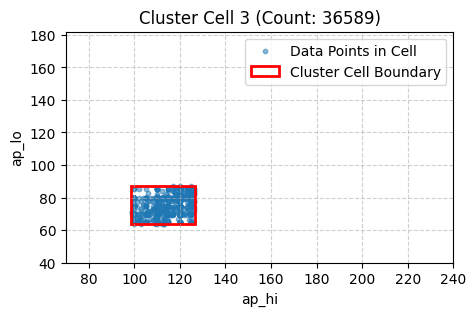


Biểu đồ cho Ô cụm 4 (Level 1, Count 1452)


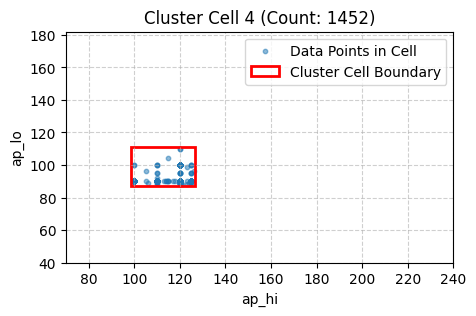


Biểu đồ cho Ô cụm 5 (Level 1, Count 152)


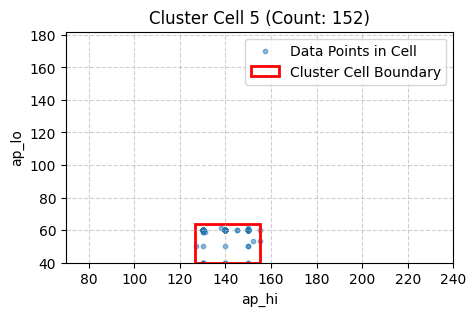


Biểu đồ cho Ô cụm 6 (Level 1, Count 8955)


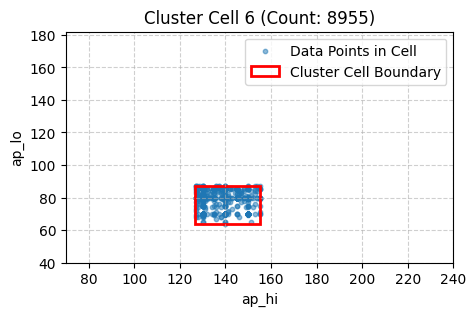


Biểu đồ cho Ô cụm 7 (Level 1, Count 14041)


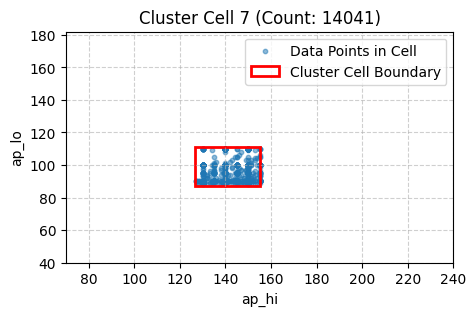


Biểu đồ cho Ô cụm 8 (Level 1, Count 588)


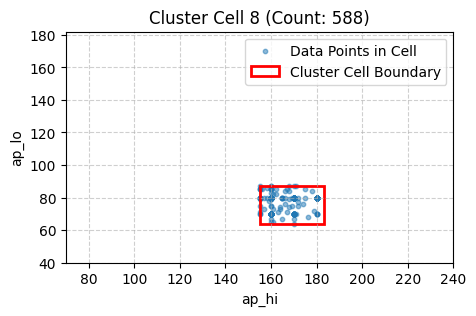


Biểu đồ cho Ô cụm 9 (Level 1, Count 3520)


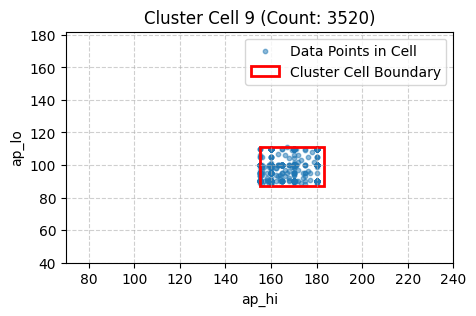


Biểu đồ cho Ô cụm 10 (Level 1, Count 143)


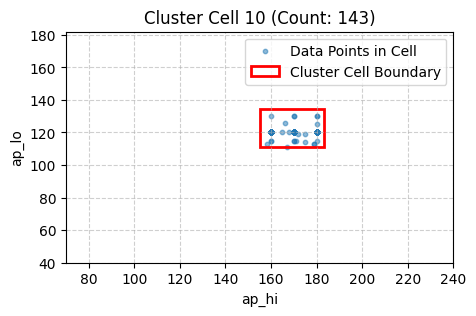


Biểu đồ cho Ô cụm 11 (Level 1, Count 170)


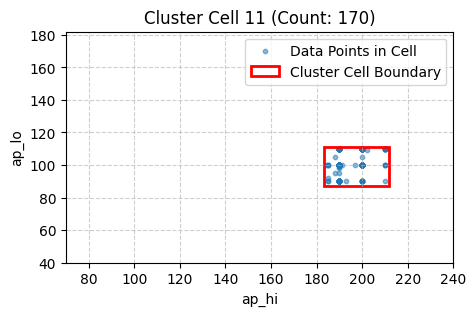

In [ ]:
print("\n--- Trực quan hóa từng ô cụm riêng biệt ---")

if clusters_found_cells:
    for i, cell in enumerate(clusters_found_cells):
        print(f"\nBiểu đồ cho Ô cụm {i} (Level {cell.level}, Count {cell.count})")

        # Lọc các điểm dữ liệu gốc nằm trong ranh giới của ô cụm hiện tại
        points_in_cell = data_for_sting[
            np.all(data_for_sting >= cell.min_coords, axis=1) &
            np.all(data_for_sting <= cell.max_coords, axis=1)
        ]

        plt.figure(figsize=(5, 3))

        if len(points_in_cell) > 0:
            plt.scatter(points_in_cell[:, 0], points_in_cell[:, 1], alpha=0.5, s=10, label='Data Points in Cell')

        # Vẽ hình chữ nhật biểu diễn ranh giới của ô cụm
        rect = plt.Rectangle((cell.min_coords[0], cell.min_coords[1]),
                             cell.max_coords[0] - cell.min_coords[0],
                             cell.max_coords[1] - cell.min_coords[1],
                             fill=False, color='red', linewidth=2, label='Cluster Cell Boundary')
        plt.gca().add_patch(rect)

        plt.title(f'Cluster Cell {i} (Count: {cell.count})')
        plt.xlabel(numerical_features[0])
        plt.ylabel(numerical_features[1])
        plt.xlim(data_min_bounds[0], data_max_bounds[0]) # Giữ trục x cố định
        plt.ylim(data_min_bounds[1], data_max_bounds[1]) # Giữ trục y cố định
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.show()
else:
    print("Không có cụm nào được tìm thấy để trực quan hóa riêng biệt.")

In [ ]:
# --- Tính toán các chỉ số đánh giá cụm ---

# Bước 1: Gán nhãn cụm cho từng điểm dữ liệu dựa trên ô cụm
# Tạo một mảng nhãn cụm, ban đầu gán -1 (nhiễu hoặc không thuộc cụm nào)
cluster_labels = np.full(len(data_for_sting), -1)

# Gán nhãn cho các điểm dữ liệu nằm trong các ô cụm đã tìm thấy
# Mỗi ô cụm sẽ được gán một nhãn duy nhất
cell_to_label = {id(cell): i for i, cell in enumerate(clusters_found_cells)}

for i, point in enumerate(data_for_sting):
    # Tìm ô lá mà điểm thuộc về (để đảm bảo nhất quán với cách chèn dữ liệu)
    # Cần một phương thức trong lớp STING để tìm ô lá cho một điểm
    # Hiện tại, ta có thể lặp qua tất cả các ô cụm đã tìm thấy và kiểm tra
    for cell in clusters_found_cells:
        # Kiểm tra xem điểm có nằm trong ranh giới của ô cụm không
        if np.all(point >= cell.min_coords) and np.all(point <= cell.max_coords):
            cluster_labels[i] = cell_to_label[id(cell)]
            break # Điểm chỉ thuộc về một ô cụm

# Lọc ra các điểm dữ liệu đã được gán vào một cụm (nhãn >= 0)
clustered_points_indices = cluster_labels >= 0
data_clustered = data_for_sting[clustered_points_indices]
labels_clustered = cluster_labels[clustered_points_indices]

print("\n--- Đánh giá hiệu quả gom cụm ---")

if len(set(labels_clustered)) < 2 or len(data_clustered) < 2:
    print("Không đủ cụm hoặc điểm dữ liệu để tính các chỉ số đánh giá.")
else:
    # Silhouette Score: Đo lường mức độ tương đồng của một đối tượng với cụm của chính nó (độ kết dính)
    # so với các cụm khác (độ tách biệt). Giá trị cao hơn tốt hơn (gần 1).
    try:
        silhouette_avg = silhouette_score(data_clustered, labels_clustered)
        print(f"Silhouette Score: {silhouette_avg:.4f}")
    except ValueError as e:
        print(f"Không thể tính Silhouette Score: {e}")


    # Davies-Bouldin Index: Đo lường tỷ lệ giữa sự phân tán trong cụm và khoảng cách giữa các tâm cụm.
    # Giá trị thấp hơn tốt hơn (gần 0).
    try:
        db_index = davies_bouldin_score(data_clustered, labels_clustered)
        print(f"Davies-Bouldin Index: {db_index:.4f}")
    except ValueError as e:
         print(f"Không thể tính Davies-Bouldin Index: {e}")


    # Calinski-Harabasz Index (Variance Ratio Criterion): Đo lường tỷ lệ giữa
    # phương sai giữa các cụm và phương sai trong cụm. Giá trị cao hơn tốt hơn.
    try:
        ch_index = calinski_harabasz_score(data_clustered, labels_clustered)
        print(f"Calinski-Harabasz Index: {ch_index:.4f}")
    except ValueError as e:
        print(f"Không thể tính Calinski-Harabasz Index: {e}")


--- Đánh giá hiệu quả gom cụm ---
Silhouette Score: 0.4288
Davies-Bouldin Index: 0.7351
Calinski-Harabasz Index: 32698.4386


In [ ]:
print("\n--- Lấy ra một số mẫu trong mỗi ô cụm ---")

# Kiểm tra xem có cụm nào được tìm thấy không
if clusters_found_cells:
    sample_size_per_cell = 5 # Số lượng mẫu muốn lấy từ mỗi ô cụm

    for i, cell in enumerate(clusters_found_cells):
        print(f"\n--- Mẫu từ Ô cụm {i} (Level {cell.level}, Count {cell.count}) ---")

        # Lọc các điểm dữ liệu gốc nằm trong ranh giới của ô cụm hiện tại
        # Lưu ý: Việc này có thể tốn bộ nhớ nếu tập dữ liệu gốc rất lớn.
        # Một cách hiệu quả hơn là lưu trữ chỉ số của các điểm trong mỗi ô khi chèn dữ liệu,
        # nhưng điều đó đòi hỏi thay đổi cấu trúc lớp GridCell.
        points_in_cell = data_for_sting[
            np.all(data_for_sting >= cell.min_coords, axis=1) &
            np.all(data_for_sting <= cell.max_coords, axis=1)
        ]

        if len(points_in_cell) > 0:
            # Lấy ngẫu nhiên một số mẫu từ các điểm trong ô
            if len(points_in_cell) > sample_size_per_cell:
                sampled_points = points_in_cell[np.random.choice(len(points_in_cell), size=sample_size_per_cell, replace=False)]
            else:
                sampled_points = points_in_cell # Lấy tất cả nếu số lượng ít hơn kích thước mẫu

            # Tạo DataFrame tạm thời để hiển thị mẫu dễ đọc hơn
            # Sử dụng features_for_sting làm tên cột vì data_for_sting hiện là dữ liệu PCA
            df_sampled = pd.DataFrame(sampled_points, columns=numerical_features)
            print(df_sampled)
        else:
            print("Ô này được xác định là cụm nhưng không có điểm dữ liệu gốc nào nằm chính xác trong ranh giới sau khi lọc.")

else:
    print("Không có cụm nào được tìm thấy, không thể lấy mẫu.")


--- Lấy ra một số mẫu trong mỗi ô cụm ---

--- Mẫu từ Ô cụm 0 (Level 1, Count 875) ---
   ap_hi  ap_lo
0     90     50
1     90     60
2     90     60
3     90     60
4     90     60

--- Mẫu từ Ô cụm 1 (Level 1, Count 184) ---
   ap_hi  ap_lo
0     90     70
1     90     70
2     90     70
3     90     70
4     90     65

--- Mẫu từ Ô cụm 2 (Level 1, Count 1780) ---
   ap_hi  ap_lo
0    100     60
1    120     60
2    120     60
3    100     60
4    105     60

--- Mẫu từ Ô cụm 3 (Level 1, Count 36589) ---
   ap_hi  ap_lo
0    120     70
1    120     80
2    120     80
3    100     70
4    100     70

--- Mẫu từ Ô cụm 4 (Level 1, Count 1452) ---
   ap_hi  ap_lo
0    120    100
1    110     90
2    120     90
3    120     90
4    120     90

--- Mẫu từ Ô cụm 5 (Level 1, Count 152) ---
   ap_hi  ap_lo
0    130     60
1    130     60
2    130     60
3    130     60
4    130     60

--- Mẫu từ Ô cụm 6 (Level 1, Count 8955) ---
   ap_hi  ap_lo
0    130     80
1    130     80
2    140     